In [21]:
#Initialize some stuff
import requests
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from gridstatus import EIA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import UCSmpl

load_dotenv("../.env")

False

In [ ]:
# Get tracking the sun data on installed $/W of residential PV
# This won't work out of the box. The data is on AWS but it's raw so there's no summaries by sector at the national level. The quick and dirty approach is to open the link below, then copy/paste the 'download csv' link into the code.
# https://emp-lbnl.shinyapps.io/tts_visualization/
pv_costs_raw_url = ("https://emp-lbnl.shinyapps.io/tts_visualization/_w_95b5848b963e4e9d8f7da0e3414b5624/session/dc003610d6428980a5ee72952c22c567/download/dtPL1?w=95b5848b963e4e9d8f7da0e3414b5624")

pv_costs_raw = pd.read_csv(pv_costs_raw_url)

In [4]:
# Get EIA data on average residential electric rates
# https://www.eia.gov/opendata/browser/electricity/retail-sales?frequency=annual&data=price;&facets=sectorid;stateid;&sectorid=RES;&stateid=US;&sortColumn=period;&sortDirection=desc;

# Instantiate the EIA client to get the API key
eia = EIA()

# API url
url = (
    "https://api.eia.gov/v2/electricity/retail-sales/data/"
    "?frequency=annual"
    "&data[0]=price"
    "&facets[sectorid][]=RES"
    "&facets[stateid][]=US"
    "&sort[0][column]=period"
    "&sort[0][direction]=desc"
    "&offset=0"
    "&length=5000"
)

# Set up headers with the API key
headers = {
    "X-Api-Key": eia.api_key
}

# Send the GET request to the API
r = requests.get(url, headers=headers)
r.raise_for_status()  # Raise an error if the request failed

# Parse and load the response data into a DataFrame
response = r.json()['response']
print(f"Total records: {response['total']}")

res_costs_raw = pd.DataFrame(response['data'])

Total records: 24


In [19]:
# Combine the datasets into a new dataframe
# Make sure the period column matches 'Year'
res_costs_raw = res_costs_raw.rename(columns={"period": "Year"})
res_costs_raw['Year'] = res_costs_raw['Year'].astype(int)
res_costs_raw['price'] = res_costs_raw['price'].astype(float)
pv_costs_raw['Year'] = pv_costs_raw['Year'].astype(int)

# Merge the two dataframes on Year and sort
costs_df = pd.merge(pv_costs_raw, res_costs_raw, on="Year", how="outer")
costs_df = costs_df.sort_values("Year").reset_index(drop=True)

# Keep only the columns you care about
costs_df = costs_df[["Year", "Median", "price"]]
costs_df = costs_df.dropna()

costs_df = costs_df.rename(columns={
    "Median": "PV_Median_Cost",
    "price": "Residential_Electricity_Price"
})

costs_df

,Year,PV_Median_Cost,Residential_Electricity_Price
1,2001,14.0,8.58
2,2002,14.3,8.44
3,2003,12.9,8.72
4,2004,12.0,8.95
5,2005,11.4,9.45
6,2006,11.6,10.40
7,2007,11.9,10.65
8,2008,11.4,11.26
9,2009,10.8,11.51
10,2010,9.2,11.54


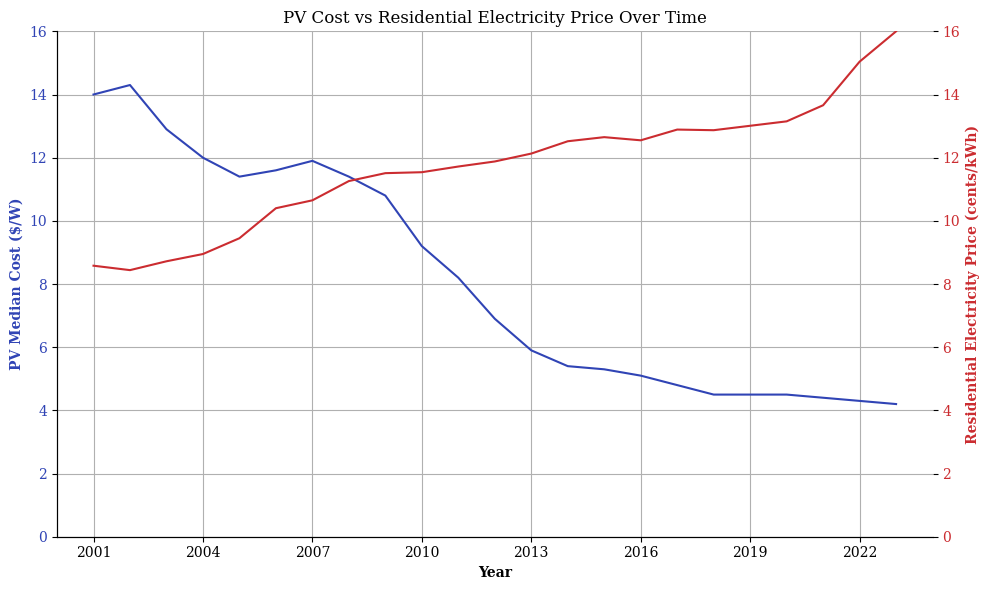

In [24]:
with plt.style.context('ucs_light'):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Define colors
    pv_color = "#3044B5"
    price_color = "#CB2C30"

    # PV cost on the left axis
    ax1.plot(costs_df["Year"], costs_df["PV_Median_Cost"], color=pv_color, label="PV Median Cost")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("PV Median Cost ($/W)", color=pv_color)
    ax1.tick_params(axis="y", labelcolor=pv_color)
    ax1.set_ylim(0, 16)
    ax1.grid(True)

    # Set x-axis limits based on the Year column, and ensure it's only integer values
    ax1.set_xlim(costs_df["Year"].min()-1, costs_df["Year"].max()+1)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Electric cost on the right axis  
    ax2.plot(costs_df["Year"], costs_df["Residential_Electricity_Price"], color=price_color, label="Residential Electricity Price")
    ax2.set_ylabel("Residential Electricity Price (cents/kWh)", color=price_color)
    ax2.tick_params(axis="y", labelcolor=price_color)
    ax2.set_ylim(0, 16)

    plt.title("PV Cost vs Residential Electricity Price Over Time")
    fig.tight_layout()
    plt.savefig('pv-vs-elec-cost.png', dpi=100)
    plt.show()

